# Comparing the German Constitutional Debt Brake and the EU Fiscal Rules

This file compares implications of the new EU fiscal framework with those of the German constitutional debt brake.

In [1]:
# Set autoreleoad
%load_ext autoreload
%autoreload 2

# Import libraries and modules
import sys
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
import matplotlib.pyplot as plt

# Import DSA model class and stochastic subclass
sys.path.append(os.path.abspath('..'))
from classes import StochasticDsaModel as DSA
from functions import *

## Compare 7-year adjustment period

In [2]:
# Implications of the EU fiscal rules under November 2024 forecasts
model = DSA(country='DEU', adjustment_period=7)
model.find_spb_binding()

                  Model Params                              SPB Targets       
================================================     =========================
country                                      DEU     main_adjustment     0.016
adjustment period                              7     lower_spb           0.366
adjustment start                            2025     financial_stress    0.052
shock frequency                        quarterly     adverse_r_g         0.374
stochastic period                      2032-2037     deficit_reduction  -0.674
estimation                                normal     stochastic          0.391
bond level data                            False     debt_safeguard      0.561
safeguards         EDP, debt, deficit_resilience     binding             0.561
================================================     =========================

                                Binding Params                                
spb_steps                             0.13, 0.13, 0

In [3]:
# Save EU results
eu_spb_target = model.spb_target
eu_results = model.df('sb', 'ob', 'ngdp').reset_index().loc[model.adjustment_start:model.adjustment_end]

In [4]:
# Calculate implications of enforced constiutional debt brake
def calc_debt_brake(model):
    """
    Find SPB path consistent with a 0.35 percent structural deficit
    """

    model.project()
    adj_year = 0 

    # If sb is less then -0.35, increase by 0.001
    while (model.sb[model.adjustment_start + adj_year] < -0.35 and adj_year < model.adjustment_period):
    
        # Initiate spb step at lower bound increase by 0.001
        model.spb_steps[adj_year] += 0.001

        # Project using new steps
        model.project(
            spb_steps=model.spb_steps,
        )

        # If sb is -0.35, move to next period
        if model.sb[model.adjustment_start + adj_year] >= -0.35:
            adj_year += 1

# Apply debt brake optimizer to dsa model
calc_debt_brake(model)

In [5]:
# Save constitutional debt brake results
db_spb_target = model.spb_target
db_results = model.df('sb', 'ob', 'ngdp').reset_index().loc[model.adjustment_start:model.adjustment_end]

In [6]:
# Compare results
def comp_results(eu_results, db_results, adj_period):
    """
    Compare EU fiscal rule and debt brake results
    """

    # Merge results
    results = eu_results.merge(db_results, on='y', suffixes=('_eu', '_db'))

    # Calculate differences
    for col in ['sb_eu', 'sb_db', 'ob_eu', 'ob_db']:
        results[col] = results[col] * -1
        results[f'{col}_abs'] = results[col] * results[f'ngdp_{col[-2:]}'] / 100
    
    results['sb_diff'] = results['sb_eu'] - results['sb_db']
    results['ob_diff'] = results['ob_eu'] - results['ob_db']
    
    results['sb_diff_abs'] = results['sb_eu_abs'] - results['sb_db_abs'] 
    results['ob_diff_abs'] = results['ob_eu_abs'] - results['ob_db_abs'] 

    sb_diff = results['sb_diff'].mean()
    sb_diff_abs = results['sb_diff_abs'].mean()
    ob_diff = results['ob_diff'].mean()
    ob_diff_abs = results['ob_diff_abs'].mean()

    # print results
    print(f'2025-{2024+adj_period} Difference between strucutural deficit:')
    print(f'Average yearly difference as percent of GDP: {sb_diff:.2f}')
    print(f'Average yearly difference in billion EUR: {sb_diff_abs:.2f}')
    print()
    print(f'2025-{2024+adj_period} Difference between overall deficit:')
    print(f'Average yearly difference as percent of GDP: {ob_diff:.2f}')
    print(f'Average yearly difference in billion EUR: {ob_diff_abs:.2f}')

    return results

results = comp_results(eu_results, db_results, 7)

2025-2031 Difference between strucutural deficit:
Average yearly difference as percent of GDP: 0.71
Average yearly difference in billion EUR: 34.07

2025-2031 Difference between overall deficit:
Average yearly difference as percent of GDP: 0.63
Average yearly difference in billion EUR: 30.83


In [7]:
# Plot the additional fiscal space implied by Fiscal Rules
def plot_comp(results, abs=False, rot=0, save=True):
    """
    Plot comparison of fiscal space implied by Fiscal Rules and Debt Brake
    """

    if abs: 
        cols = ['sb_db_abs', 'sb_diff_abs']
        label = '(EUR bn)'
        file = 'abs'
    else:
        cols = ['sb_db', 'sb_diff']
        label = '(% of GDP)'
        file = 'pct'
    
    fig, ax = plt.subplots()
    results[cols].plot(kind='bar', stacked=True, ax=ax)
    ax.set_xticklabels(results['y'], rotation=0)
    # ax.set_ylabel(f'Structural Deficit {label}')
    ax.set_title(f'Germany: Permitted Structural Deficit {label}')
    plt.xticks(rotation=rot)
    ax.legend(['Debt Brake', 'EU Rules'])
    ax.set_axisbelow(True)
    plt.tight_layout()
    if save:
        plt.savefig(f'structural_deficit_{results["y"].max()}_{file}.jpeg', dpi=300)
    plt.show()

: 

In [ ]:
plot_comp(results)

: 

In [ ]:
plot_comp(results, abs=True)

: 

## Compare two consecutive adjustment periods (7+4)

In [10]:
# Run model for two oncsecutive applications of the EU rules
cons_model = run_consecutive_dsa(
        'DEU',
        adjustment_start=2025, 
        initial_adjustment_period=7, 
        consecutive_adjustment_period=4, 
        number_of_adjustment_periods=2
)

# Save consecutive EU results
cons_eu_spb_target_1 = cons_model.spb[cons_model.adjustment_start+6]
cons_eu_spb_target_2 = cons_model.spb_target
cons_eu_results = cons_model.df('sb', 'ob', 'ngdp').reset_index().loc[cons_model.adjustment_start:cons_model.adjustment_end]

{'main_adjustment': 0.01589999999983112, 'lower_spb': 0.36589999999983175, 'financial_stress': 0.051899999999830915, 'adverse_r_g': 0.3743999999998319, 'deficit_reduction': -0.6744000000001686, 'stochastic': -10.557274256260461, 'debt_safeguard': 0.5607999999998325, 'binding': 0.5607999999998325}
{'main_adjustment': -0.6484000000001684, 'lower_spb': -0.300300000000169, 'financial_stress': -0.6088000000001683, 'adverse_r_g': -0.2543000000001685, 'deficit_reduction': -1.1089000000001688, 'stochastic': -0.45261583958153095, 'binding': -0.2543000000001685}


In [11]:
# Find SPB path consistent with a 0.35 percent structural deficit
calc_debt_brake(cons_model)

# Save consecutive debt brake results
cons_db_spb_target_1 = cons_model.spb[cons_model.adjustment_start+6]
cons_db_spb_target_2 = cons_model.spb_target
cons_db_results = cons_model.df('sb', 'ob', 'ngdp').reset_index().loc[cons_model.adjustment_start:cons_model.adjustment_end]

In [12]:
# Compare consecutive results
cons_results = comp_results(cons_eu_results, cons_db_results, 11)

print(f'SPB target 2031: EU {cons_eu_spb_target_1:.3f}, DB {cons_db_spb_target_1:.3f}')
print(f'SPB target 2035: EU {cons_eu_spb_target_2:.3f}, DB {cons_db_spb_target_2:.3f}')


2025-2035 Difference between strucutural deficit:
Average yearly difference as percent of GDP: 0.80
Average yearly difference in billion EUR: 42.26

2025-2035 Difference between overall deficit:
Average yearly difference as percent of GDP: 0.71
Average yearly difference in billion EUR: 37.95
SPB target 2031: EU 0.561, DB 0.882
SPB target 2035: EU -0.254, DB 0.885


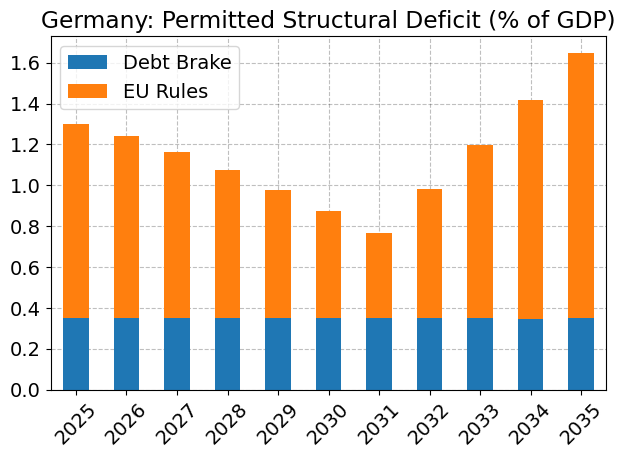

In [13]:
plot_comp(cons_results, rot=45)

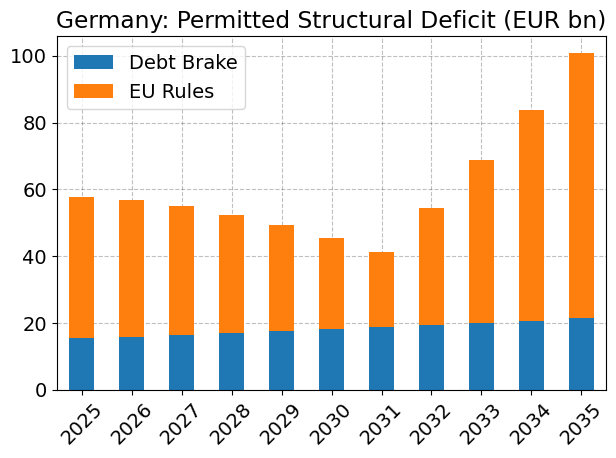

In [14]:
plot_comp(cons_results, abs=True, rot=45)